# Tutorial 4 - Segmentation (Train)

## Open Dataset : Lumbar vertebra segmentation CT image database

http://spineweb.digitalimaginggroup.ca/spineweb/index.php?n=Main.Datasets#Dataset_7.3A_Intervertebral_Disc_Localization_and_Segmentation.3A_3D_T2-weighted_Turbo_Spin_Echo_MR_image_Database

In [2]:
## Python 3.6
from __future__ import absolute_import, division, print_function
import os
import glob
import numpy as np
import h5py
import matplotlib.pyplot as plt


import keras
from keras.models import *
from keras.layers import Input, merge, BatchNormalization, AtrousConvolution2D, Conv2D, MaxPooling2D, UpSampling2D, Dropout, Cropping2D, concatenate
from keras.layers.advanced_activations import PReLU

from keras.optimizers import *
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.callbacks import  ModelCheckpoint, CSVLogger, ReduceLROnPlateau, LearningRateScheduler

from models.custom_model import UNet_like, UNet_like2


## Parameter Setting

In [3]:
#############################################
img_size = 512 
img_type = "png"
save_date = '1029'
model_name = "UNet_like_epoch100_aug.hdf5" # UNet_like_epoch100.hdf5
#############################################

## Path Setting

In [4]:
train_img_path = "../Dataset/Lumbar Vertebrae Semgnetation/Train/image"
train_label_path = "../Dataset/Lumbar Vertebrae Semgnetation/Train/mask"
test_img_path = "../Dataset/Lumbar Vertebrae Semgnetation/Test/image"
test_label_path = "../Dataset/Lumbar Vertebrae Semgnetation/Test/mask"
npy_path = "../Dataset/Lumbar Vertebrae Semgnetation/npy"

save_path = os.path.join(os.getcwd(), 'Result/saved_model')
if not os.path.isdir(save_path):
    os.makedirs(save_path)    
model_path = os.path.join(save_path, model_name)

tf_graph_path = './Result/tf_graph/'    
if not os.path.isdir(tf_graph_path):
    os.makedirs(tf_graph_path)   
    
graph_path = './Result/graph_log/'    
if not os.path.isdir(graph_path):
    os.makedirs(graph_path)   

graph_path = './Result/result_csv/'    
if not os.path.isdir(graph_path):
    os.makedirs(graph_path)     

## Load Train Dataset

### File Format Conversion (.png to .npy)

In [5]:
def create_train_data(train_img_path, train_label_path, npy_path, img_size, img_type):
    i = 0
    imgs = glob.glob(train_img_path + "/*." + img_type)
    imgdatas = np.ndarray((len(imgs), img_size, img_size,1), dtype=np.uint8)

    for imgname in imgs:
        img = load_img(imgname, grayscale = True)
        img = img_to_array(img)
        imgdatas[i] = img

        if i % 100 == 0:
            print('Done: {0}/{1} images'.format(i+1, len(imgs)))
        i += 1
        
    np.save(npy_path + '/image_train.npy', imgdatas)
    print('Saving to image .npy files done.\n')   
    
    i = 0
    labels = glob.glob(train_label_path + "/*." + img_type)
    labeldates = np.ndarray((len(labels),img_size, img_size,1), dtype=np.uint8)
    
    for labelname in labels:
        label = load_img(labelname, grayscale = True)
        label = img_to_array(label)
        labeldates[i] = label
        
        if i % 100 == 0:
            print('Done: {0}/{1} masks'.format(i+1, len(labels)))
        i += 1
        
    np.save(npy_path + '/mask_train.npy', labeldates)
    print('Saving to label .npy files done.\n')

    
def create_test_data(test_img_path, test_label_path, npy_path, img_size, img_type):
    i = 0
    imgs = glob.glob(test_img_path + "/*." + img_type)
    
    ### sorting ###
    filenames_img = []
    for k in range(len(imgs)):
        filename = test_img_path +"/"+ str(k+1).zfill(5) + "." + img_type
        filenames_img.append(filename)
        imgs = filenames_img
        
    imgdatas = np.ndarray((len(imgs), img_size, img_size,1), dtype=np.uint8)
    for imgname in imgs:
        img = load_img(imgname, grayscale = True)
        img = img_to_array(img)
        imgdatas[i] = img

        if i % 100 == 0:
            print('Done: {0}/{1} images'.format(i+1, len(imgs)))
        i += 1
        
    np.save(npy_path + '/image_test.npy', imgdatas)
    print('Saving to image .npy files done.\n')   
    
    i = 0
    labels = glob.glob(test_label_path + "/*." + img_type)
    
    ### sorting ###
    filenames_label = []
    for k in range(len(labels)):
        filename = test_label_path +"/"+ str(k+1).zfill(5) + "." + img_type
        filenames_label.append(filename)
        labels = filenames_label
        
    labeldates = np.ndarray((len(labels),img_size, img_size,1), dtype=np.uint8)
    for labelname in labels:
        label = load_img(labelname, grayscale = True)
        label = img_to_array(label)
        labeldates[i] = label
        
        if i % 100 == 0:
            print('Done: {0}/{1} masks'.format(i+1, len(labels)))
        i += 1
        
    np.save(npy_path + '/mask_test.npy', labeldates)
    print('Saving to label .npy files done.')


In [7]:
create_train_data(train_img_path, train_label_path, npy_path, img_size, img_type)
create_test_data(test_img_path, test_label_path, npy_path, img_size, img_type)

/Users/dhlee/.local/lib/python3.6/site-packages/keras_preprocessing/image.py:487: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '


Done: 1/500 images
Done: 101/500 images
Done: 201/500 images
Done: 301/500 images
Done: 401/500 images
Saving to image .npy files done.

Done: 1/500 masks
Done: 101/500 masks
Done: 201/500 masks
Done: 301/500 masks
Done: 401/500 masks
Saving to label .npy files done.

Done: 1/248 images
Done: 101/248 images
Done: 201/248 images
Saving to image .npy files done.

Done: 1/248 masks
Done: 101/248 masks
Done: 201/248 masks
Saving to label .npy files done.


### Load .npy

In [8]:
""" Train """

## Image
image_train = np.load(npy_path+"/image_train.npy")
image_train = image_train.astype('float32')
image_train /= 255

## Mask
mask_train = np.load(npy_path+"/mask_train.npy")
mask_train = mask_train.astype('float32')
mask_train /= 255
mask_train[mask_train > 0.5] = 1
mask_train[mask_train <= 0.5] = 0

    
print("*** Loading Dataset Complete")

*** Loading Dataset Complete


## Augmentation

- 생략

## Load Model

### Task 1 : Design U-Net 

[]

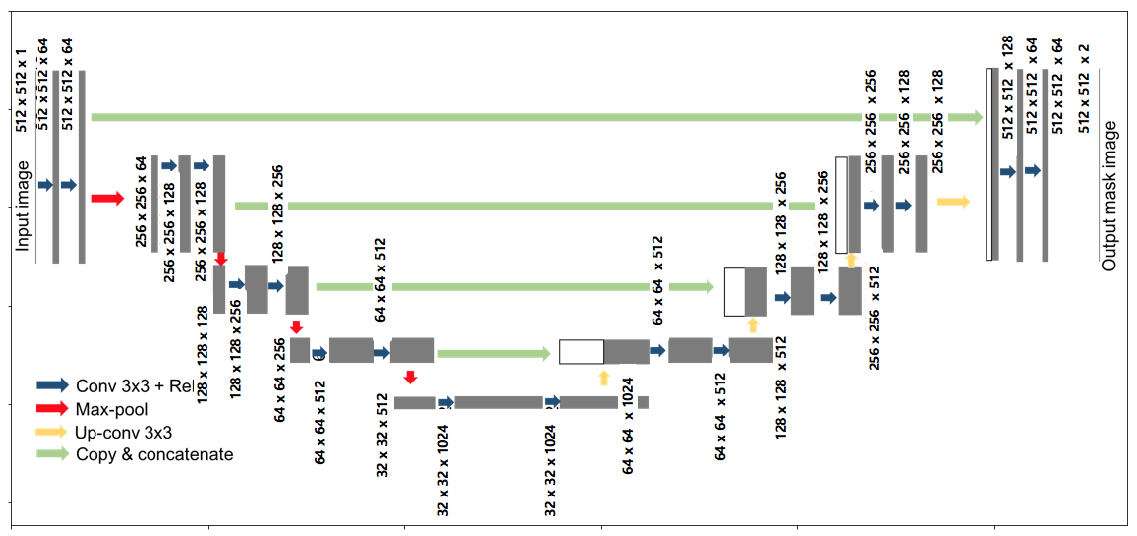

In [9]:
plot = plt.imread('./assets/unet.png')
plt.figure(figsize=(20,10))
plt.imshow(plot)

frame = plt.gca()
frame.axes.xaxis.set_ticklabels([])
frame.axes.yaxis.set_ticklabels([])

- Conv size : 3x3
- Depth : 64 -> 128 -> 256 -> 512 -> 1024 -> 512 -> 256 -> 128 -> 64
- MaxPooling2D <-> UpSampling2D (interpolation : 'nearest' or 'bilinear')

![](https://github.com/vdumoulin/conv_arithmetic/blob/master/gif/no_padding_no_strides_transposed.gif?raw=true)

In [13]:
input_tensor = Input(shape=(img_size, img_size, 1))

""" Task 1"""
model = UNet_like(input_tensor = input_tensor) 

""" Task 2"""
# model = UNet_like2(input_tensor = input_tensor) 

model.compile(optimizer = Adam(lr = 1e-4), loss = 'binary_crossentropy', metrics = ['accuracy']) ##

print("*** Loading Model Complete")

*** Loading Model Complete


### Task 2 : Design U-Net + Batch Normalization + PReLU + DropOut

[]

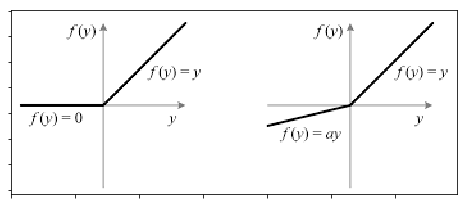

In [14]:
plot = plt.imread('./assets/prelu.png')
plt.figure(figsize=(8,4))
plt.imshow(plot)

frame = plt.gca()
frame.axes.xaxis.set_ticklabels([])
frame.axes.yaxis.set_ticklabels([])

- Conv : Conv2D -> BatchNorm -> PReLU 
- UpConv : Conv2D(UPSampling) -> PReLU -> Concatenate -> Conv2D - > PReLU) BatchNorm (x)
- output = layers.BatchNormalization(axis=3, name='conv#')(input)
- output = layers.PReLU(shared_axes=[1, 2], name='prelu#')(input)

- Conv4, Conv5 마지막에 Dropout 추가
- output = layers.Dropout(0.5)(input) 

### Display Network 

In [6]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot, plot_model

model.summary()
# SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))

NameError: name 'model' is not defined

## Model Callbacks (Save)

In [16]:
################################################################################################################
################################################################################################################
model_checkpoint = ModelCheckpoint(model_path, monitor='loss', verbose=1, save_best_only = True, mode='min') #'val_loss/min', 'val_acc/max'
reducer = ReduceLROnPlateau(monitor='loss', factor=.8, patience=5, verbose=1, mode='auto', epsilon=0.0001, cooldown=0, min_lr=0)
logger = CSVLogger(graph_path + save_date + '.txt', separator=',', append = False)
tb_hist = keras.callbacks.TensorBoard(log_dir=tf_graph_path, histogram_freq=0, write_graph = True, write_images=True)

callbacks = [model_checkpoint, reducer, logger, tb_hist]

################################################################################################################
################################################################################################################

/Users/dhlee/anaconda/envs/tensorflow3/lib/python3.6/site-packages/keras/callbacks.py:999: UserWarning: `epsilon` argument is deprecated and will be removed, use `min_delta` instead.
  warnings.warn('`epsilon` argument is deprecated and '


## Train Model

In [ ]:
model.fit(image_train, 
          mask_train, 
          batch_size= 3, 
          epochs = 100, 
          verbose = 1, 
          validation_split = 0.2, ###
          shuffle = True, ###
          callbacks=[model_checkpoint])

print("\n***** Training Model Complete *****")

Train on 400 samples, validate on 100 samples
Epoch 1/100


## Homework : Dice (Similarity) Coefficient Metric 사용

##   \\( DSC = \frac{2 * |X\cap Y|}{|X| + |Y|} \\)

[]

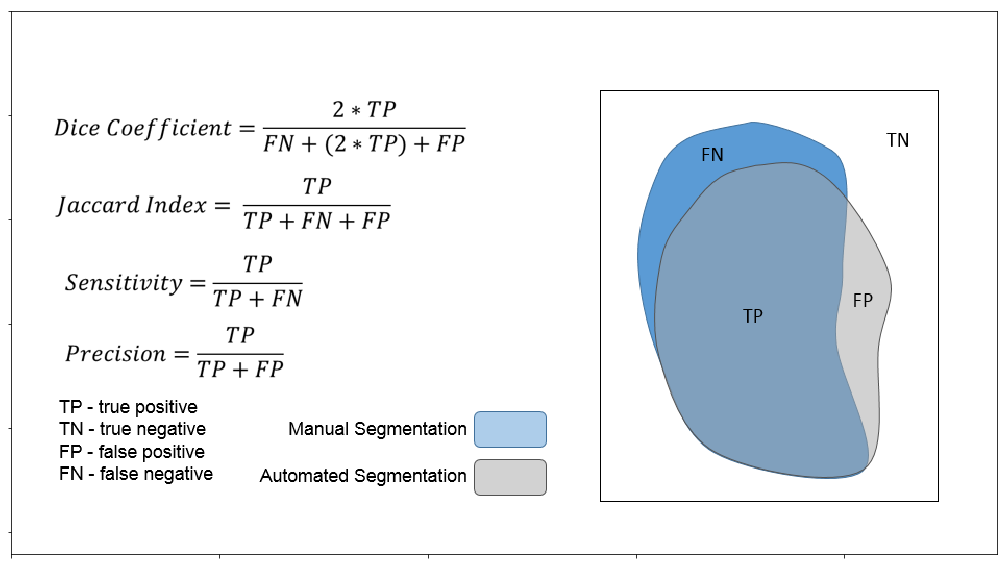

In [31]:
plot = plt.imread('./assets/metrics.png')
plt.figure(figsize=(20,10))
plt.imshow(plot)

frame = plt.gca()
frame.axes.xaxis.set_ticklabels([])
frame.axes.yaxis.set_ticklabels([])